# Notebook for image classification of Hornsund Fjord
#### Jullian C.B. Williams
##### Polish Academy of Sciences, Institute of Geophysics, Warsaw, Poland

In [ ]:
#Pip install packages where needed
#!pip install xarray
#!pip install hvplot
#!pip install rasterio
#!pip install rioxarray
#!pip install scikit-image
#!pip install spectral
#!pip install dask

In [1]:
# import libraries
import os  # for chdir, getcwd, path.basename, path.exists
import hvplot.xarray
import pandas as pd # for DatetimeIndex 
import rioxarray
import numpy as np #for log10, mean, percentile, power
import rasterio as rio
import imageio.v3 as iio
import cv2
from PIL import Image
import dask.array as da
import seaborn as sns
import matplotlib.image as mpimg
from rasterio.plot import show # plotting raster data
from rasterio.plot import show_hist #histograms of raster data

import glob # for listing files in tiff conversion function
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
from pathlib import Path    
from skimage.filters.rank import entropy #for GLCM entropy
from skimage.util import img_as_ubyte #Avoid precision loss converting image of type float32 to uint8 as required by rank filters
from sklearn.decomposition import PCA
from skimage.morphology import disk #manage disk while running
from sklearn.cluster import KMeans
from spectral import *
import spectral.io.envi as envi #run PCA

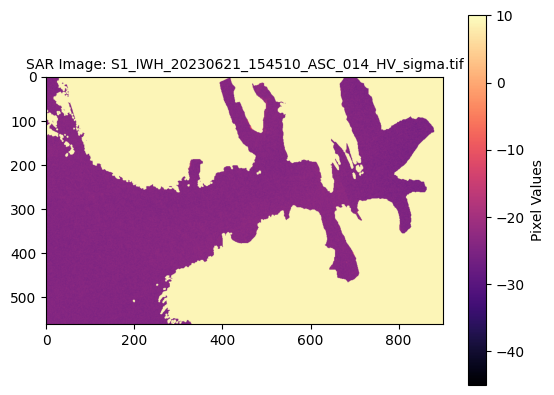

In [6]:
#This loops through existing folders and plots the first couple of images in the window.

# Define the main folder path
main_folder = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd"

# Loop through all subfolders and files
for subdir, _, files in os.walk(main_folder):
    for file in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if file.endswith(('.tif')):
            file_path = os.path.join(subdir, file)

with rio.open(file_path) as src:                                 #plots last item in file list. Indent to loop level to print all.
    img = src.read(1)
    plt.imshow(img, cmap='magma', vmin = -45, vmax = 10)  
    plt.title(f"SAR Image: {file}", fontsize=10)
    plt.colorbar(label="Pixel Values")
    plt.show()

            

In [7]:
#Get filenames of fjord clipped images 

# Define the main folder path
main_folder = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd"

# Loop through all subfolders and files
for subdir, _, files in os.walk(main_folder):
    for file in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if file.endswith(('.tif')):
            file_path = os.path.join(subdir, file)
            
print(file_path) #plots last item in file list. Indent to loop level to print all.

            

C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd\S1_CLIPPED\IW\2022\S1_IWH_20230621_154510_ASC_014_HV_sigma.tif


In [47]:
# Define the folder containing the images
folder_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/EW/2014/"

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    
    # Check if the file is a raster image (e.g., .tif)
    if file_name.endswith(".tif"):
        try:
            # Open the raster image using Rasterio
            with rio.open(file_path) as src:
                print(f"Opened {file_name}")
                # Access metadata or data as needed
                print(src.meta)  # Metadata
                # Example: Read the first band
                band1 = src.read(1)
        except Exception as e:
            print(f"Error opening {file_name}: {e}")

Opened S1_EWM_20141014_063020_DES_125_HH_sigma.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 901, 'height': 561, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(50.0, 0.0, 498975.0,
       0.0, -50.0, 8559025.0)}
Opened S1_EWM_20141014_063020_DES_125_HV_sigma.tif
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 901, 'height': 561, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 8

In [9]:
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/IWStack.tif'
src = rio.open(filename)

n_bands = src.meta['count']
img_shape = src.shape

band_numbers = ['1', '2', '3', '4']
pc_names = ['PC1', 'PC2', 'PC3', 'PC4']

band_names = ['VH',
              'VV',
              'HH',
              'HV']

In [10]:
stats_raw = []

for idx, band in enumerate(src.read()):

    stats_raw.append({
        'band': idx + 1,
        'min': band.min(),
        'mean': band.mean(),
        'median': np.median(band),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
        'vmin': int(band.mean() - np.std(band)),
        'vmax': int(band.mean() + np.std(band)),

    })

summary_stats = pd.DataFrame.from_records(
    stats_raw, index='band').astype(int)

summary_stats

,min,mean,median,max,std,var,vmin,vmax
band,,,,,,,,
1,-27,-5,9,9,16,270,-21,11
2,-26,-2,9,14,13,184,-16,10
3,-25,-1,9,9,12,159,-14,10
4,-27,-5,9,9,16,266,-21,11


Text(0.5, 1.0, 'HV')

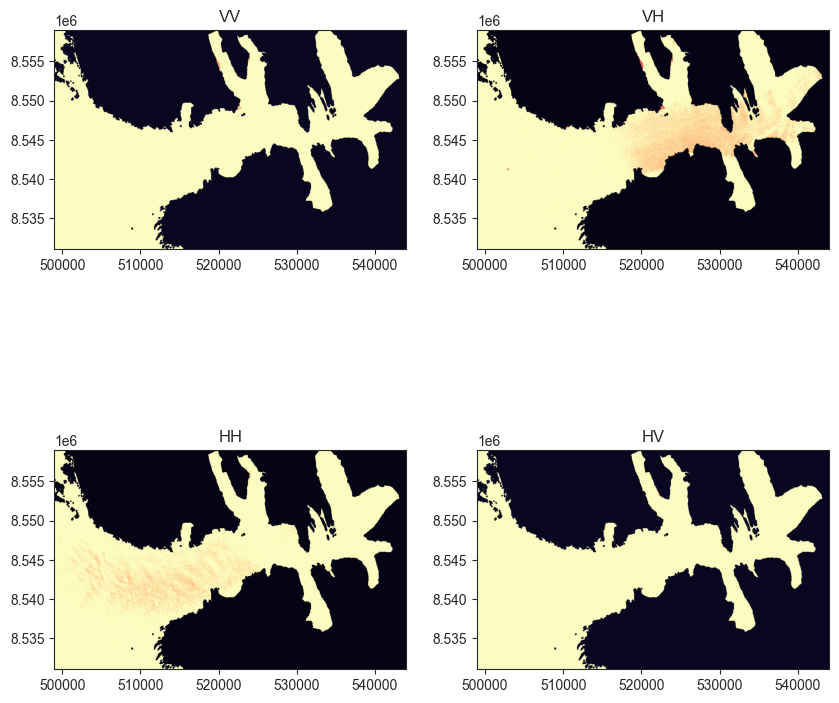

In [83]:
fig = plt.figure(figsize=(10,10))
cmap = plt.get_cmap('inferno_r')

ax1 = plt.subplot2grid((2,2), (0,0))
ax2 = plt.subplot2grid((2,2), (0,1))
ax3 = plt.subplot2grid((2,2), (1,0))
ax4 = plt.subplot2grid((2,2), (1,1))

show((src, 1), cmap='magma_r', ax=ax1, vmin=stats[0]['vmin'], vmax=stats[0]['vmax'])
show((src, 2), cmap='magma_r', ax=ax2, vmin=stats[1]['vmin'], vmax=stats[1]['vmax'])
show((src, 3), cmap='magma_r', ax=ax3, vmin=stats[2]['vmin'], vmax=stats[2]['vmax'])
show((src, 4), cmap='magma_r', ax=ax4, vmin=stats[3]['vmin'], vmax=stats[3]['vmax'])

ax1.set_title('VV')
ax2.set_title('VH')
ax3.set_title('HH')
ax4.set_title('HV')

In [11]:
bnd_list = []
for i in range(n_bands):
    bnd = da.from_array(src.read(i+1))
    bnd_list.append(bnd)

dask_band_stack = da.dstack(bnd_list)
dask_band_stack = dask_band_stack.rechunk('auto')
src_sr = dask_band_stack.compute()

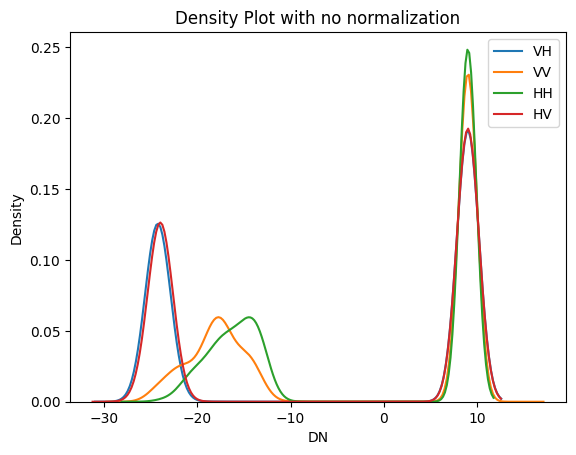

In [49]:
for i in range(n_bands):
    sns.kdeplot(src_sr[:, :, i].flatten())

plt.title('Density Plot with no normalization')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(band_names)

In [12]:
flat_bnds = np.zeros((src_sr[:, :, 0].size, n_bands))

for i in range(n_bands):
    bnd_i = src_sr[:, :, i].flatten()
    bnd_norm = 1024*((bnd_i - bnd_i.min())/(bnd_i.max() - bnd_i.min()))
    flat_bnds[:, i] = bnd_norm

In [13]:
stats_norm = []
for i in range(n_bands):
    band = flat_bnds[:, i]

    stats_norm.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
        })

smry_norm = pd.DataFrame.from_records(
    stats_norm, index='band').astype(int)

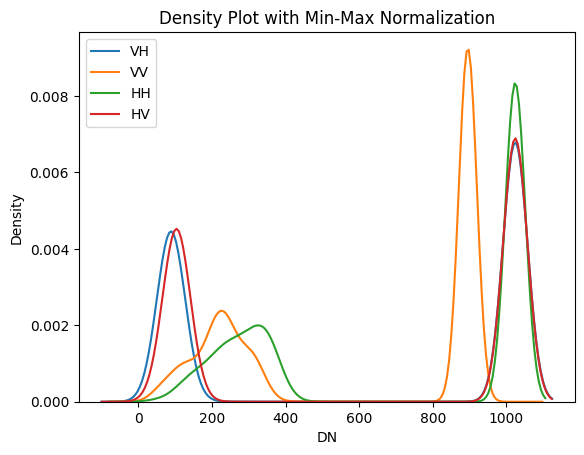

In [9]:
# look at data
for i in range(n_bands):
    sns.kdeplot(flat_bnds[:, i])

plt.title('Density Plot with Min-Max Normalization')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(band_names)

In [14]:
cor_lists = np.corrcoef(flat_bnds.transpose())

cor_data = pd.DataFrame(
    cor_lists,
    columns=band_numbers,
    index=band_numbers,
)

cor_data = round(cor_data, 2)

In [15]:
EigVal_cor, EigVec_cor = np.linalg.eig(cor_lists)

std_eigVec_table = pd.DataFrame(
    EigVec_cor,
    columns=band_numbers,
    index=band_numbers
)

std_eigVec_table = round(std_eigVec_table, 3)
std_eigVec_table

,1,2,3,4
1,0.501,0.693,0.516,-0.052
2,0.499,-0.054,-0.484,-0.717
3,0.499,0.076,-0.517,0.691
4,0.501,-0.715,0.482,0.077


In [16]:
order2 = EigVal_cor.argsort()[::-1]

EigVal_cor = EigVal_cor[order2]

In [17]:
pc_values_cor = (EigVal_cor/sum(EigVal_cor)*100).round(2)

In [18]:
value = sum(pc_values_cor[0:3])
print(f'variance accounted for by first 3 components of the std: {value}%')

variance accounted for by first 3 components of the std: 99.98%


In [19]:
loading_cor = pd.DataFrame(
    EigVec_cor * np.sqrt(EigVal_cor) / np.sqrt(np.abs(cor_lists)),
    columns=pc_names,
    index=band_names,
    )

loading_cor = round(loading_cor, 3)
loading_cor

,PC1,PC2,PC3,PC4
VH,0.998,0.092,0.054,-0.001
VV,0.999,-0.007,-0.051,-0.019
HH,1.000,0.010,-0.054,0.018
HV,0.999,-0.095,0.051,0.002


Text(0.5, 1.0, 'Information retention - standardized (correlation)')

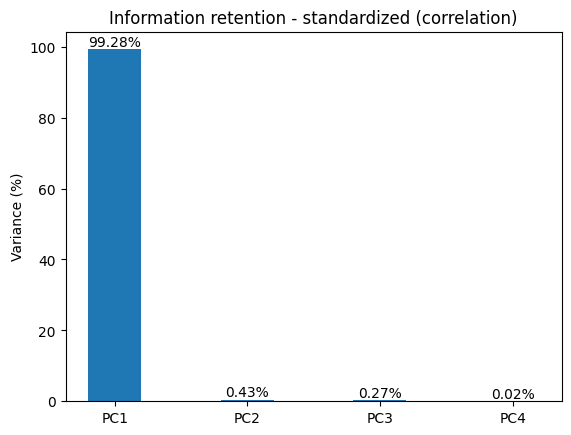

In [19]:
fig, ax = plt.subplots()

pc_bars = ax.bar(
    [1, 2, 3, 4],
    (EigVal_cor/sum(EigVal_cor)*100).round(2),
    align='center',
    width=0.4,
    tick_label=pc_names,
)

plt.bar_label(pc_bars, labels=[f'{x/100:.2%}' for x in pc_bars.datavalues])
plt.ylabel('Variance (%)')
plt.title('Information retention - standardized (correlation)')

In [20]:
PC_std = np.matmul(flat_bnds, EigVec_cor)  # cross product

print(PC_std.shape)

(505461, 4)


In [21]:
stats_std_PC = []
for i in range(n_bands):
    band = PC_std[:, i]

    stats_std_PC.append({
        'band': i + 1,
        'min': band.min(),
        'mean': band.mean(),
        'max': band.max(),
        'std': int(np.std(band)),
        'var': int(np.var(band)),
    })

smry_std_PC = pd.DataFrame.from_records(
    stats_std_PC, index='band').astype(int)

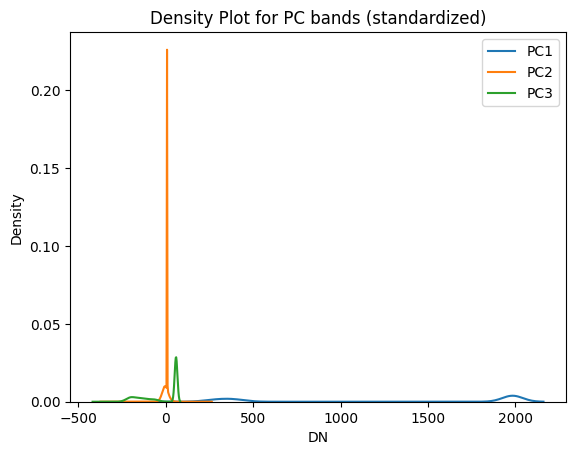

In [22]:
PC_std_2d = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d[:, :, i] = PC_std[:, i].reshape(-1, img_shape[1])

for i in range(3):
    sns.kdeplot(PC_std_2d[:, :, i].flatten())

plt.title('Density Plot for PC bands (standardized)')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(pc_names[0:3])

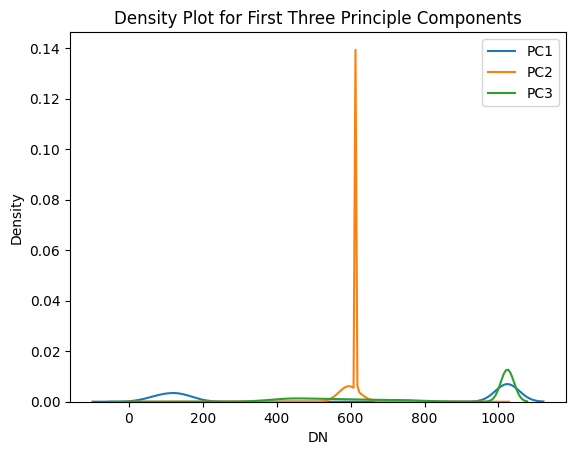

In [23]:
PC_nrm = np.zeros(PC_std.shape)

for i in range(n_bands):
    PC_i = PC_std[:, i]
    pc_norm_mm = 1024*(PC_i - PC_i.min())/(PC_i.max() - PC_i.min())
    PC_nrm[:, i] = pc_norm_mm

PC_std_2d_norm = np.zeros((img_shape[0], img_shape[1], n_bands))
for i in range(n_bands):
    PC_std_2d_norm[:, :, i] = PC_nrm[:, i].reshape(-1, img_shape[1])
for i in range(3):
    sns.kdeplot(PC_std_2d_norm[:, :, i].flatten())

plt.title('Density Plot for First Three Principle Components')
plt.xlabel('DN')
plt.ylabel('Density')
plt.legend(pc_names[0:3])

In [23]:
# 3 dimensional dummy array with zeros
MB_img = da.zeros((img_shape[0], img_shape[1], n_bands))

# stacking up images into the array
for i in range(n_bands):
    # MB_img[:,:,i] = cv2.imread('band'+str(i+1)+'.jpg', cv2.IMREAD_GRAYSCALE)  
    MB_img[:,:,i] = src.read(i+1)

# Convert 2d band array in 1-d to make them as feature vectors and Standardization
MB_matrix = da.zeros((MB_img[:,:,0].size,n_bands))

for i in range(n_bands):
    MB_array = MB_img[:,:,i].flatten()  # covert 2d to 1d array 
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()  
    MB_matrix[:,i] = MB_arrayStd

# MB_matrix.shape
MB_matrix.compute()

array([[-1.17675332, -1.51632027, -1.48566257, -1.1827826 ],
       [-1.13230031, -1.52172393, -1.47935389, -1.20623956],
       [-1.19322711, -1.56615615, -1.40247415, -1.18775009],
       ...,
       [ 0.8682231 ,  0.85939917,  0.86015365,  0.8682646 ],
       [ 0.8682231 ,  0.85939917,  0.86015365,  0.8682646 ],
       [ 0.8682231 ,  0.85939917,  0.86015365,  0.8682646 ]])

In [24]:
# Covariance
np.set_printoptions(precision=3)
cov = np.cov(MB_matrix.transpose())

# Eigen Values
EigVal,EigVec = np.linalg.eig(cov)

print("Eigenvalues:\n\n", EigVal,"\n")

Eigenvalues:

 [3.971e+00 7.079e-04 1.096e-02 1.733e-02] 



C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\dask\array\core.py:1739: FutureWarning: The `numpy.linalg.eig` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [26]:
# Ordering Eigen values and vectors
order = EigVal.argsort()[::-1]
EigVal = EigVal[order]
EigVec = EigVec[:,order]

#Projecting data on Eigen vector directions resulting to Principal Components 
PC = np.matmul(MB_matrix,EigVec)   #cross product
PC.compute()

array([[-2.680e+00,  2.968e-02,  3.262e-01, -1.014e-03],
       [-2.669e+00,  3.381e-02,  3.371e-01,  4.733e-02],
       [-2.674e+00,  1.234e-01,  2.964e-01,  9.521e-05],
       ...,
       [ 1.728e+00,  5.712e-04,  4.892e-03, -4.906e-06],
       [ 1.728e+00,  5.712e-04,  4.892e-03, -4.906e-06],
       [ 1.728e+00,  5.712e-04,  4.892e-03, -4.906e-06]])

Text(0.5, 0.98, 'Pair plot of PCs')

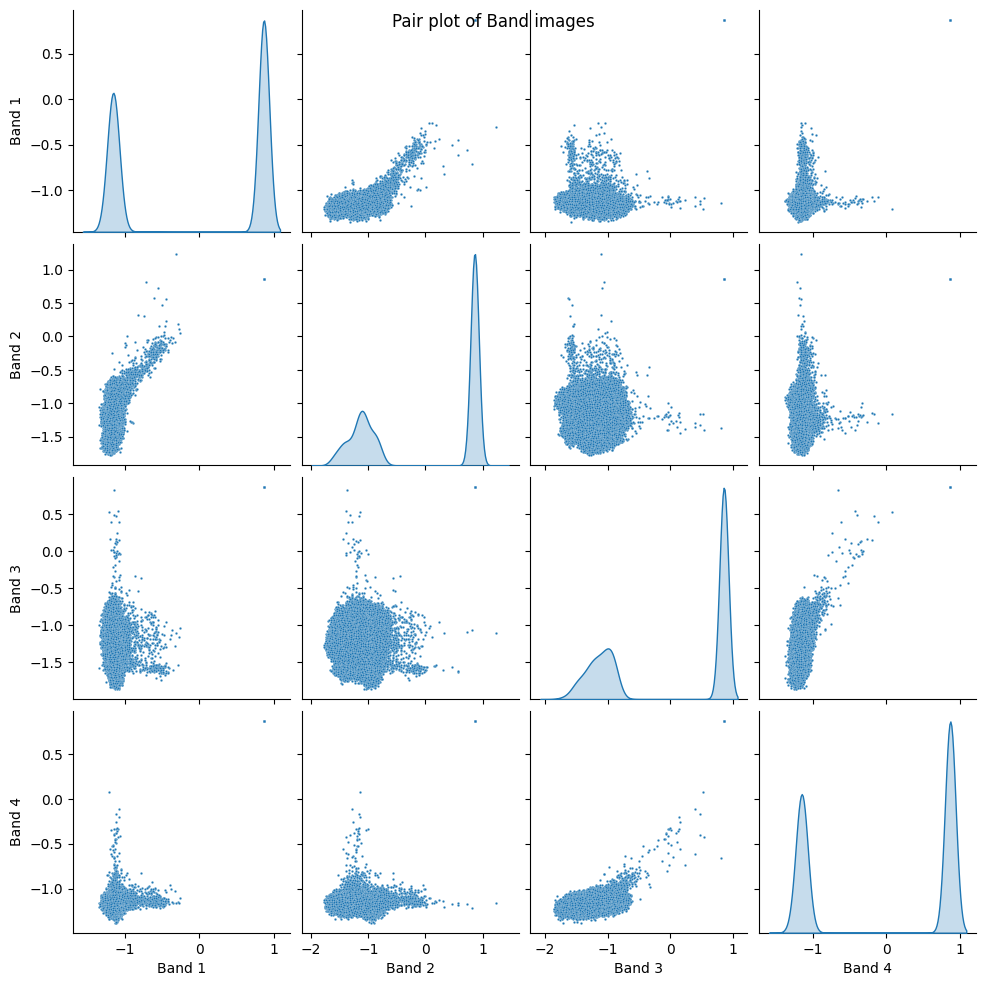

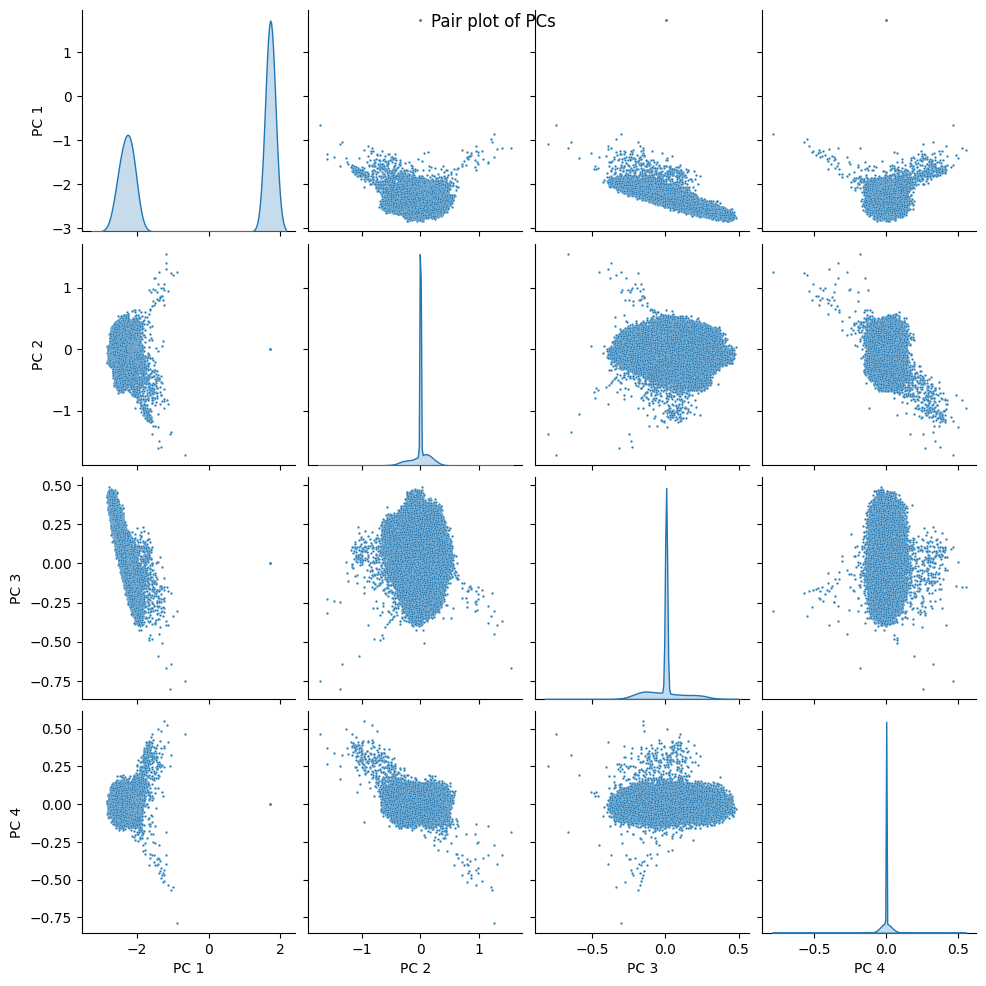

In [27]:
Bandnames = ['Band 1', 'Band 2', 'Band 3', 'Band 4']

df = pd.DataFrame(
    MB_matrix,
    columns=Bandnames)
    
# dask_df = dd.from_pandas(df)
# dask_df.compute()

a = sns.pairplot(df,
                 diag_kind='kde',
                 plot_kws={"s": 3})

a.fig.suptitle("Pair plot of Band images")

PCnames = ['PC 1', 'PC 2', 'PC 3', 'PC 4']

b = sns.pairplot(pd.DataFrame(PC, columns=PCnames),
                 diag_kind='kde',
                 plot_kws={"s": 3})

b.fig.suptitle("Pair plot of PCs")

In [25]:
kwargs = src.meta
kwargs.update(
    dtype=rio.float32,
    count=4)

In [26]:
# band, row, col
tmp_std_norm = np.moveaxis(PC_std_2d_norm, [0, 1, 2], [2, 1, 0])
PC_img_std_norm = np.swapaxes(tmp_std_norm, 1, 2)

In [27]:
with rio.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/PC_img_std_norm.tif', 'w', **kwargs) as dst:
    dst.write(PC_img_std_norm.astype(rio.float32))

In [167]:
#filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/PC_img_std_norm.tif'
filename = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/labels/img_2_train/5band_clipped.tif'

In [3]:
# Read the satellite image file into a numpy array
#image = iio.imread(filename)
#np.save('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/PC_image.npy', image)
#np.save('C:/Users/jullian.williams/Desktop/HIRLOMAP/labels/img_2_train/5band_clipped.npy', image)
#image_data = np.load('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/PC_image.npy')#
image_data = np.load('C:/Users/jullian.williams/Desktop/HIRLOMAP/labels/img_2_train/5band_clipped.npy')
print(image_data.shape)

image_data_2d = image_data.reshape(-1, image_data.shape[-1] )
print(image_data_2d.shape)

(561, 864, 5)
(484704, 5)


In [4]:
# Initialize the PCA model with 3 components
pca = PCA(n_components=3)

# Fit the model to the image data
pca.fit(image_data_2d)

# Transform the data into the PCA space
pca_results = pca.transform(image_data_2d)
pca_results.shape

(484704, 3)

(484704,)
(561, 864)


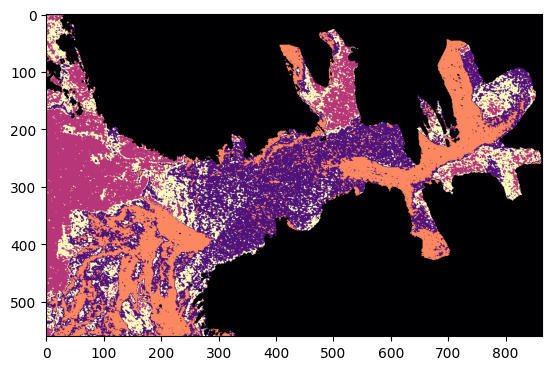

In [5]:
# # Define the number of clusters
n_clusters = 5

# Initialize the k-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')

# Fit the model to the data
kmeans.fit(pca_results)

# Predict the cluster assignments for each pixel
labels = kmeans.predict(pca_results)
print(labels.shape)
# Reshape the labels back into the original image shape
labels = labels.reshape(image_data.shape[0], image_data.shape[1])
print(labels.shape)

# Plot the image and display the results
plt.imshow(labels, cmap='magma')
#plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/labels/img_2_train/5band_kmeans2.png',dpi=1500,     #resoluton  
#            bbox_inches='tight',  # Tight layout
#            pad_inches=0.1,       # Padding
#            facecolor='white',    # Background color
#            edgecolor='none',     # Edge color
#            format='png')
#plt.show()
#'C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/Klabels.png'

In [6]:
label_to_merge =  4 
target_label = 3

In [7]:
labels[labels == label_to_merge] = target_label

In [8]:
label_to_merge =  3 
target_label = 1

In [9]:
labels[labels == label_to_merge] = target_label

(561, 864)


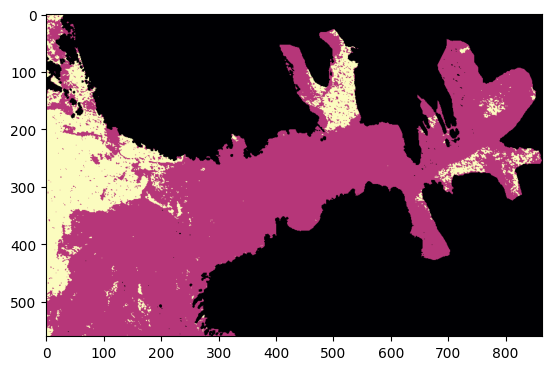

In [10]:
labels = labels.reshape(image_data.shape[0], image_data.shape[1])
print(labels.shape)

# Plot the image and display the results
plt.imshow(labels, cmap = 'magma')
plt.savefig('C:/Users/jullian.williams/Desktop/HIRLOMAP/labels/img_2_train/5band_kmeans2.png',dpi=1500,     #resoluton  
            bbox_inches='tight',  # Tight layout
            pad_inches=0.1,       # Padding
            facecolor='white',    # Background color
            edgecolor='none',     # Edge color
            format='png')

In [11]:
print(labels)

[[2 2 2 ... 0 0 0]
 [1 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 ...
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]
 [2 2 2 ... 0 0 0]]


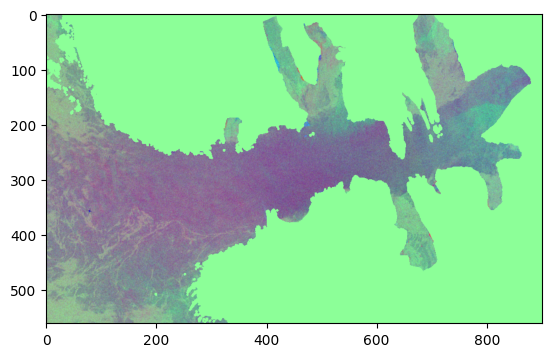

In [19]:
# Open the file:
raster = rio.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/frnd/S1_CLIPPED/stack/PC_img_std_norm.tif')

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

# Convert to numpy arrays
nir = raster.read(4)
red = raster.read(3)
green = raster.read(2)

# Normalize band DN
nir_norm = normalize(nir)
red_norm = normalize(red)
green_norm = normalize(green)

# Stack bands
nrg = np.dstack((nir_norm, red_norm, green_norm))

# View the color composite
plt.imshow(nrg)

In [24]:
print(pca_results.shape), print(labels.shape), print(image_data_2d.shape), print(image_data)

(505461, 3)
(561, 901)
(505461, 4)
(561, 901, 4)


(None, None, None, None)

In [42]:
# Get the cluster centers
centers = kmeans.cluster_centers_

print("Cluster Labels:", labels.shape)
print("Cluster Centers:", centers.shape)

Cluster Labels: (561, 901)
Cluster Centers: (5, 3)


In [156]:
#Sometimes you might want to know what colours you're using from the colourmap :D
from pylab import *

cmap = cm.get_cmap('magma', 10)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#000004
#180f3d
#440f76
#721f81
#9e2f7f
#cd4071
#f1605d
#fd9668
#feca8d
#fcfdbf


C:\Users\jullian.williams\AppData\Local\Temp\ipykernel_16164\4195463569.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma', 10)    # PiYG


References:

https://github.com/ax0n-pr1me/planet-labs-pca/blob/main/pca_calc.ipynb <br>
https://github.com/ax0n-pr1me/k-means-pca-satellite-nb <br>
https://github.com/jcbw/HeatFlux_BeaufortSea/blob/main/CalculateHeatFlux4_.ipynb <br>
https://gis.stackexchange.com/questions/306164/how-to-visualize-multiband-imagery-using-rasterio